# Using Dean Oliver's Four Factors to Predict NBA Regular Season Records

##### Goals:
- Accurately predict NBA teams' regular season records
- Determine the impact that Dean Oliver's Four Factors - shooting percentage, turnovers, offensive rebounds and free throw rate - have on an NBA team's regular season record

##### Project Sections: 
1. Import Packages
2. Clean Data
3. Expore Data with Visualizations
4. Train and Test an MLR Model

##### Data:
- Downloaded from https://cleaningtheglass.com/
- 150 observations: 30 NBA teams' data from the following 5 regular seasons: 2014-2015, 2015-2016, 2016-2017, 2017-2018, and 2018-2019 
- Our data contains the following 9 variables:
    - Wins: Number of wins a team had in a given season
    - EFG: A team's effective field goal percentage in a given season
         - Effective field goal percentage is closely related to field goal percentage, which is the percentage of attempted shots that were made
    - TPP: A team's turnover per possession percentage in a given season
    - ORP: A team's offensive rebounding percentage in a given season
         - Offensive rebounding percentage is percentage of a team's own misses that they rebounded
    - FTR: A team's free throw rate in a given season
         - FTR is the number of free throws a team made per 100 field goal attempts
    - OEFG: A team's opponents' EFG in a given season
    - OTPP: A team's opponents' TPP in a given season
    - OORP: A team's opponents OORP in a given season
    - OFTR: A team's opponents OFTR in a given season


## 1. Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 2. Clean Data

In [5]:
# Read in data
seas_18_19 = pd.read_csv('league_four_factors_3_5_2022 (1).csv')
seas_17_18 = pd.read_csv('league_four_factors_3_5_2022.csv')
seas_16_17 = pd.read_csv('league_four_factors_3_5_2022 (2).csv')
seas_15_16 = pd.read_csv('league_four_factors_3_5_2022 (3).csv')
seas_14_15 = pd.read_csv('league_four_factors_3_5_2022 (5).csv')

# Drop header row of each data set
seas_18_19.drop([0],axis=0,inplace=True)
seas_17_18.drop([0],axis=0,inplace=True)
seas_16_17.drop([0],axis=0,inplace=True)
seas_15_16.drop([0],axis=0,inplace=True)
seas_14_15.drop([0],axis=0,inplace=True)

# Append each season into one data set
four_factors = seas_18_19.append(seas_17_18,ignore_index=True).append(seas_16_17,ignore_index=True).append(seas_15_16,ignore_index=True).append(seas_14_15,ignore_index=True)

# Create a data subset that only contains the 9 variables
four_factors = four_factors[[u'W',u'OFFENSE: eFG%',u'OFFENSE: TOV%',u'OFFENSE: ORB%',u'OFFENSE: FT Rate',
             u'DEFENSE: eFG%',u'DEFENSE: TOV%',u'DEFENSE: ORB%',u'DEFENSE: FT Rate']]

# Rename variables
four_factors = four_factors.rename(columns={u'W':'Wins',u'OFFENSE: eFG%':'EFG',u'OFFENSE: TOV%':'TPP',
                             u'OFFENSE: ORB%':'ORP',u'OFFENSE: FT Rate':'FTR',
                             u'DEFENSE: eFG%':'OEFG',u'DEFENSE: TOV%':'OTPP',
                             u'DEFENSE: ORB%':'OORP',u'DEFENSE: FT Rate':'OFTR'})


four_factors['EFG'] = four_factors.apply(lambda x: float(re.search(r'[\d\.]+',x['EFG']).group(0)),axis=1)
four_factors['TPP'] = four_factors.apply(lambda x: float(re.search(r'[\d\.]+',x['TPP']).group(0)),axis=1)
four_factors['ORP'] = four_factors.apply(lambda x: float(re.search(r'[\d\.]+',x['ORP']).group(0)),axis=1)
four_factors['OEFG'] = four_factors.apply(lambda x: float(re.search(r'[\d\.]+',x['OEFG']).group(0)),axis=1)
four_factors['OTPP'] = four_factors.apply(lambda x: float(re.search(r'[\d\.]+',x['OTPP']).group(0)),axis=1)
four_factors['OORP'] = four_factors.apply(lambda x: float(re.search(r'[\d\.]+',x['OORP']).group(0)),axis=1)

## 3. Explore Data with Visualizations

Below we use boxplots to compare the team with the worst record over the 5 seasons with the team with the best record over the 5 seasons.  As expected the 2015-2016 Warriors had a greater EFG, ORP, and FTR than the 2015-2016 Sixers.  We are also not surprised to see that that Warriors team had a lower TPP, OEFG, OORP, and OFTR than that Philly Team.  We are surprised to see, however, that Philly had a greater ORPP than Golden State.  Apparently, in 2015-2016 opponents of Philly turned the ball over more than opponents of Golden State.  All in all, we are not surprised to find that the team with the best record from 2014-2019 exceeded the team with the worst record from 2014-2019 in 7 of the 8 statistics we are considering.  Most notably, Golden State is almost considered an outlier in terms of high EFG while Philly is below the 25th percentile in EFG.

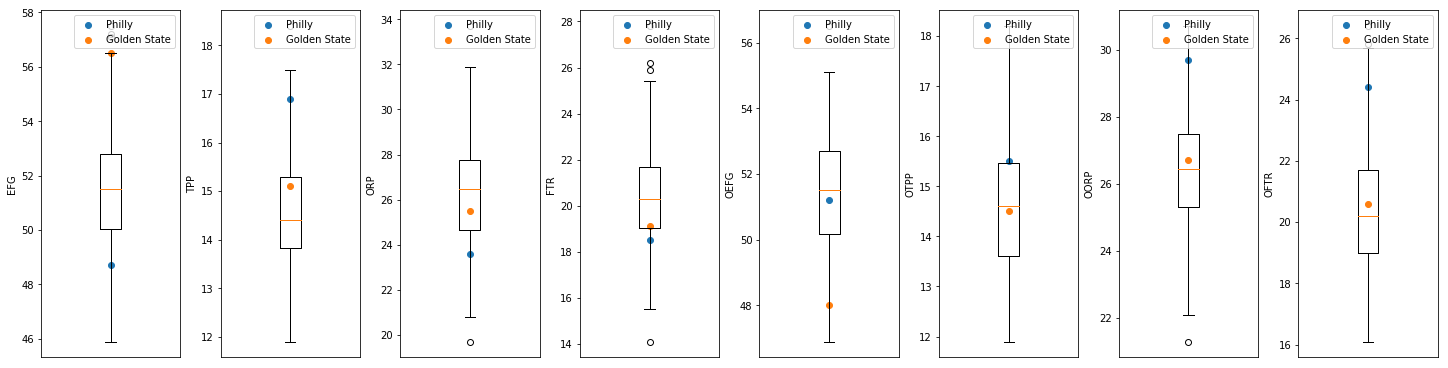

In [24]:
# 2015-2016 Sixers
worst_team = four_factors.sort_values(by='Wins').reset_index(drop=True).loc[[0]]
# 2015-2016 Warriors
best_team = four_factors.sort_values(by='Wins',ascending=False).reset_index(drop=True).loc[[0]]

fig,axes = plt.subplots(1,8,figsize=(20,5))
axes[0].boxplot(four_factors['EFG'])
axes[0].set_ylabel('EFG')
axes[0].scatter([1], worst_team['EFG'],label='Philly')
axes[0].scatter([1], best_team['EFG'],label='Golden State')
axes[0].legend()
axes[0].set_xticks([])
axes[1].boxplot(four_factors['TPP'])
axes[1].set_ylabel('TPP')
axes[1].scatter([1], worst_team['TPP'],label='Philly')
axes[1].scatter([1], best_team['TPP'],label='Golden State')
axes[1].legend()
axes[1].set_xticks([])
axes[2].boxplot(four_factors['ORP'])
axes[2].set_ylabel('ORP')
axes[2].scatter([1], worst_team['ORP'],label='Philly')
axes[2].scatter([1], best_team['ORP'],label='Golden State')
axes[2].legend()
axes[2].set_xticks([])
axes[3].boxplot(four_factors['FTR'])
axes[3].set_ylabel('FTR')
axes[3].scatter([1], worst_team['FTR'],label='Philly')
axes[3].scatter([1], best_team['FTR'],label='Golden State')
axes[3].legend()
axes[3].set_xticks([])
axes[4].boxplot(four_factors['OEFG'])
axes[4].set_ylabel('OEFG')
axes[4].scatter([1], worst_team['OEFG'],label='Philly')
axes[4].scatter([1], best_team['OEFG'],label='Golden State')
axes[4].legend()
axes[4].set_xticks([])
axes[5].boxplot(four_factors['OTPP'])
axes[5].set_ylabel('OTPP')
axes[5].scatter([1], worst_team['OTPP'],label='Philly')
axes[5].scatter([1], best_team['OTPP'],label='Golden State')
axes[5].legend(loc='upper right')
axes[5].set_xticks([])
axes[6].boxplot(four_factors['OORP'])
axes[6].set_ylabel('OORP')
axes[6].scatter([1], worst_team['OORP'],label='Philly')
axes[6].scatter([1], best_team['OORP'],label='Golden State')
axes[6].legend(loc='upper right')
axes[6].set_xticks([])
axes[7].boxplot(four_factors['OFTR'])
axes[7].set_ylabel('OFTR')
axes[7].scatter([1], worst_team['OFTR'],label='Philly')
axes[7].scatter([1], best_team['OFTR'],label='Golden State')
axes[7].legend(loc='upper right')
axes[7].set_xticks([])
fig.tight_layout(pad=0.3)
plt.show()

##### Multiple linear regression models are predicated on the following five assumptions:

1. Linear relationship exists between each predictor variable and the response variable
2. Independent variables are not correlated with each other
3. The observations are independent
4. Residuals have constant variance at every point in the model.
5. Residuals of the model are normally distributed

We proceed to test whether our proposed model satisfies these assumptions

##### We test Assumption 1 of MLR models below, i.e. each independent variable has a linear relationship with the dependent variable
The graphs below show that EFG and OEFG have linear relationships with Wins.  The other graphs do not clearly show linear relationships between the independent variables and the Wins variable.  We proceed to calculate Pearson coefficients between each indep. variable and the Wins variable to determine whether or not the predictor variables truly have a linear relationship with Wins.

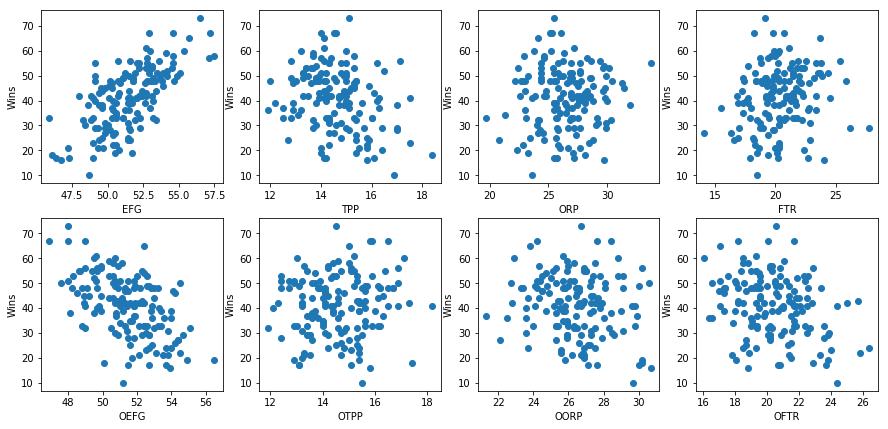

In [25]:
fig, ax = plt.subplots(2,4,figsize = (15,7))
ax[0,0].scatter(four_factors['EFG'],four_factors['Wins'])
ax[0,0].set_xlabel('EFG')
ax[0,0].set_ylabel('Wins')
ax[0,1].scatter(four_factors['TPP'],four_factors['Wins'])
ax[0,1].set_xlabel('TPP')
ax[0,1].set_ylabel('Wins')
ax[0,2].scatter(four_factors['ORP'],four_factors['Wins'])
ax[0,2].set_xlabel('ORP')
ax[0,2].set_ylabel('Wins')
ax[0,3].scatter(four_factors['FTR'],four_factors['Wins'])
ax[0,3].set_xlabel('FTR')
ax[0,3].set_ylabel('Wins')
ax[1,0].scatter(four_factors['OEFG'],four_factors['Wins'])
ax[1,0].set_xlabel('OEFG')
ax[1,0].set_ylabel('Wins')
ax[1,1].scatter(four_factors['OTPP'],four_factors['Wins'])
ax[1,1].set_xlabel('OTPP')
ax[1,1].set_ylabel('Wins')
ax[1,2].scatter(four_factors['OORP'],four_factors['Wins'])
ax[1,2].set_xlabel('OORP')
ax[1,2].set_ylabel('Wins')
ax[1,3].scatter(four_factors['OFTR'],four_factors['Wins'])
ax[1,3].set_xlabel('OFTR')
ax[1,3].set_ylabel('Wins')

plt.show()

According to the correlation scatterplot below, Wins appears to have the highest linear correlation with EFG and OEFG.  As EFG increases Wins increases, and as OEFG increases Wins decreases.  The other predictor variables do not have large correlations with Wins, which may lead to an unreliable multiple linear regression model.

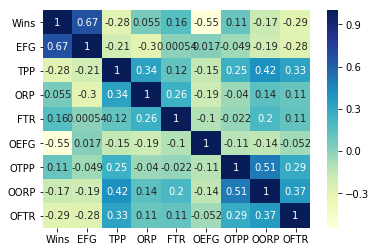

In [26]:
# Calculate Pearson correlation coefficients
sns.heatmap(four_factors.corr(), cmap="YlGnBu", annot = True)
plt.show()

## 4. Fit a MLR to Our Data to Predict Teams' Regular Season Wins

In [27]:
# Separate the data into a training sets and testing sets of predictor and response variables
X_train, X_test, y_train, y_test = train_test_split(four_factors[['EFG','TPP','ORP','FTR','OEFG','OTPP','OORP','OFTR']], four_factors['Wins'], train_size = 0.7, 
                                                    test_size = 0.3, random_state = 12)

# We add an extra column of 1's to X_train and X_test so that the our model does not take the default intercept of 0
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the model on our training data
model = sm.OLS(y_train,X_train_sm).fit()

##### Below we test Assumption 2 of our MLR model, i.e. the independent variables are not correlated with each other
We calculate variance inflation factors for each predictor variable in our model.
Since each VIF is less than 5, we can safely say that our predictor variables are not correlated with each other.


In [28]:
VIF_list = [variance_inflation_factor(X_train_sm.values, i)
                          for i in range(len(X_train_sm.columns))]
VIF = pd.DataFrame()
VIF.append(VIF_list[1:]).rename(columns={0:'VIF'}).rename(index={0:'EFG',1:'TPP',2:'ORP',
                                                                 3:'FTR',4:'OEFG',5:'OTPP',
                                                                 6:'OORP',7:'OFTR'})

,VIF
EFG,1.225760
TPP,1.414139
ORP,1.324908
FTR,1.166759
OEFG,1.135567
OTPP,1.517270
OORP,1.835612
OFTR,1.402811


#### We use the statistics below to assess how well our model fits training data
- The P-value for each predictor variable is less than .05, so each predictor variable has a non-zero impact on Wins
- $R^2$ of the model is .938, which means that 93.8% of the variance in teams' wins is explained by the predictor variables
- The P-value of the F-statistic is low, which also means that the predictor variables' inclusion in the model improves the model

In summary, the our model fits the training data well and predicts the response variable well.

#### Furthermore, we verify that we have met Assumption 3 of our MLR model - the observations in our data are not correlated
From below we can see that our Durbin-Watson statistic is close to ~2 (the DW statistic is always between 0 and 4), so we can safely say the residuals are not are independent.  Thus, the observations in our model's underlying data are independent.

In [29]:
# Display metrics that show model's accuracy
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Wins   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     182.8
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           1.36e-54
Time:                        12:37:18   Log-Likelihood:                -270.67
No. Observations:                 105   AIC:                             559.3
Df Residuals:                      96   BIC:                             583.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0866     17.272      0.873      0.385     -19.199      49.372
EFG            3.8039      0.164     23.158      0.000       3.478       4.130
TPP           -3.2041      0.328     -9.765      0.000      -3.855      -2.553
ORP            1.3674      0.155      8.849      0.000       1.061       1.674
FTR            0.7153      0.154      4.640      0.000       0.409       1.021
OEFG          -3.4549      0.186    -18.533      0.000      -3.825      -3.085
OTPP           2.8379      0.306      9.278      0.000       2.231       3.445
OORP          -0.9362      0.226     -4.141      0.000      -1.385      -0.487
OFTR          -0.6288      0.188     -3.345      0.001      -1.002      -0.256
==============================================================================
Omnibus:                        0.830   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.906
Skew:                           0.108   Prob(JB):                        0.636
Kurtosis:                       2.599   Cond. No.                     4.74e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### We now test Assumption 4 of our MLR model, i.e. the residuals have constant variance at every point of our model
Below we graph the standardized residuals vs. the fitted values of our model to test this assumption.  At every fitted value the standardized residuals have appear to have a constant variance.  Therefore, Assumption 4 holds.

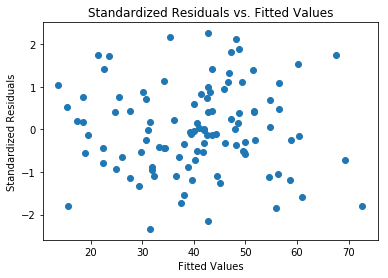

In [30]:
# Standardized residuals
influence = model.get_influence()
standardized_residuals = influence.resid_studentized_internal
fittedvalues = model.fittedvalues
fig = plt.figure()
plt.scatter(fittedvalues,standardized_residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals vs. Fitted Values')
plt.show()

##### We now test Assumption 5 of our model, i.e. the residuals are normally distributed.  
Because the points in the Q-Q plot below mostly follow a straight line, we can safely say the residuals are normally distributed.  We have verified Assumptions 2-5 of our MLR model.  We were not able to verify Assumption 1, i.e. all of the independent variables have a linear relationship with Wins.  We will address this issue if we find that our MLR model is unreliable or inaccurate.

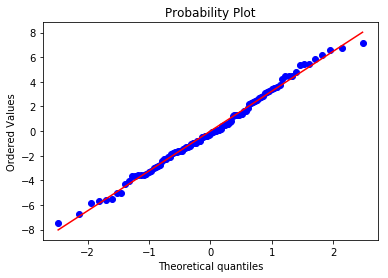

In [31]:
# Fitted values of our model
y_train_pred = model.predict(X_train_sm)

# Q-Q Plot
stats.probplot(y_train-y_train_pred,plot=plt)
plt.show()

Below we test whether or not our model can accurately predict Wins for data it has never seen before, i.e. we test our model on the testing data set.
The $R^2$ of our model on the testing data is worse than the $R^2$ of our model on the training set by only 2%.  Thus, we can safely say that our model did not overfit the training data and predicts Wins well.

In [32]:
# Predicted wins using testing data
y_test_pred = model.predict(X_test_sm)
print('R^2 on Training Data: ' + str(r2_score(y_train, y_train_pred)))
print('R^2 on Testing Data: ' + str(r2_score(y_test, y_test_pred)))

R^2 on Training Data: 0.9384120482790779
R^2 on Testing Data: 0.9212045584099492


## Conclusions

We have just shown that our eight predictor variables can accurately predict the number of wins in a team's season.  We will now analyze our model's coefficients to determine the extent to which they impact Wins.
First, the P-value of each of our 8 variables is much less than .05, so we can confidently say that each variable has an impact on Wins.  

##### EFG vs. OEFG
EFG (effective field goal percentage) influences Wins more than OEFG.  Increasing EFG by 1% adds 3.8 wins to a team's record, while decreasing a team's OEFG (the EFG of a team's opponents) by 1% adds only 3.45 wins to a teams record. 

##### TPP vs. OTPP
TPP (percentage of a team's possessions that end in a turnover) influences Wins more than OTPP (opponents' TPP).  Decreasing a team's TPP by 1% adds 3.20 wins to its record, while increasing a team's OTPP 1% only adds 2.84 wins to a team's record.  

##### ORP vs. OORP
ORP (offensive rebounding percentage), influences wins more than OORP (opponents' OORP).  Increasing a team's ORP by 1% adds 1.36 wins to their record while decreasing a team's OORP by 1% only adds .94 wins to the team's record. 

##### FTR vs. OFTR
FTR (free throw rate), influences wins more than OFRT (opponents FTR).  Increasing a team's FTR by 1% adds an average of .72 wins to its record, while decreasing a team's OFTR by 1% adds only .63 wins to the team's record.  

##### Each of the four comparisons above suggest that a team's offensive activity affects wins more than its defensive activity.  None of the signs of the coefficients surprise us either; as EFG increases Wins increases, as TPP increases Wins decreases, etc...